# Create return triangle chart

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import yfinance as yf
from numba import jit

Function for the CAGR calculation, accelerated with numba (1min --> 1sec)

In [2]:
@jit(nopython=True)
def CAGR(ratio, time):
	return 100 * (ratio ** (1 / time) - 1)

Function to calculate the actual triangle values:

In [3]:
@jit(nopython=True)
def triangle(dates, values):
	l = len(values)
	matrix = np.zeros((l, l))
	for i in range(l):
		for j in range(i+1, l):
			time = dates[j] - dates[i]
			ratio = values[j] / values[i]
			if values[i] > 0 and time > 0:
				matrix[j, i] = CAGR(ratio, time)
	return matrix

Choose symbol for data, to be pulled from Yahoo Finance. Here we're using the Dow Jones Index:

In [6]:
symbol = "^DJI"
hist = yf.Ticker(symbol).history(period="max")
decimal_dates = (hist.index.year + (hist.index.dayofyear - 1) / 365).to_numpy()
values = hist.loc[:,"Close"].to_numpy()

Create the triangle matrix, and rotate it so that the "sell" date runs to the right, and "buy" upwards:

In [7]:
matrix = triangle(decimal_dates, values)
matrix = np.rot90(matrix)
matrix = np.rot90(matrix)
matrix = np.flipud(matrix)

Create the figure:
- Normalize color intensity in [1,99] percentile with 0-midpoint
- Use Diverging red-blue colormap

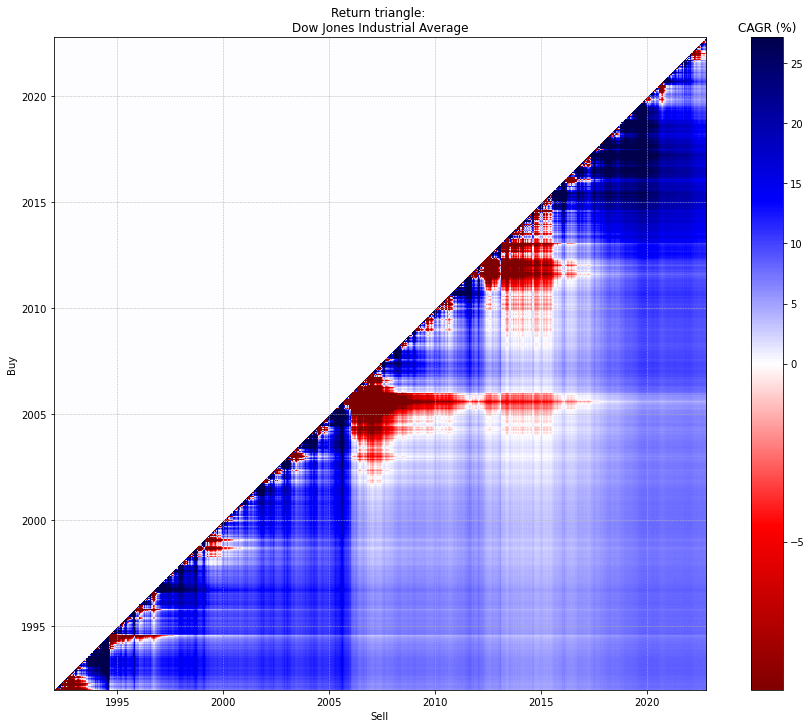

In [21]:
fig, ax = plt.subplots(figsize=(16,12))
divnorm = mcolors.TwoSlopeNorm(
	vmin=np.percentile(matrix, 1), 
	vcenter=0, 
	vmax=np.percentile(matrix, 99)
	)
start_date = np.min(decimal_dates)
end_date = np.max(decimal_dates)
cax = plt.imshow(
	matrix, 
	interpolation='none', 
	cmap="seismic_r",
	norm=divnorm, 
	extent=[start_date,end_date,start_date,end_date]
		)
cbar = fig.colorbar(cax)
cbar.ax.set_title('CAGR (%)')
plt.grid(linestyle='--', linewidth=0.5)
plt.title("Return triangle: " + "\n" + yf.Ticker(symbol).info["shortName"])
plt.xlabel("Sell")
plt.ylabel("Buy")
ax.ticklabel_format(useOffset=False)
plt.show()